In [1]:
from utils import read_intan as ri
from utils import signal_preprocessing as spp
from utils import simple_plot as pt
from spike_detection_algorithms.SpikeDetector import SpikeDetector

Successfully imported RHD utilities


In [2]:
raw_dir = './data/raw/250707_pedot/pedot_3ch_250707_1_250707_070150'
df, _ = ri.rhd_folder_to_dataframe(raw_dir)
sampling_rate = spp.get_sampling_rate(df)

Found 12 RHD files in ./data/raw/250707_pedot/pedot_3ch_250707_1_250707_070150
Successfully loaded data from pedot_3ch_250707_1_250707_070150.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070150.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070250.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070250.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070350.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070350.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070450.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070450.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070550.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070550.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070650.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070650.rhd
Successfully loaded data from pedot_3ch_250707_1_250707_070750.rhd
Successfully loaded data from pedot_3ch_250707_1_2

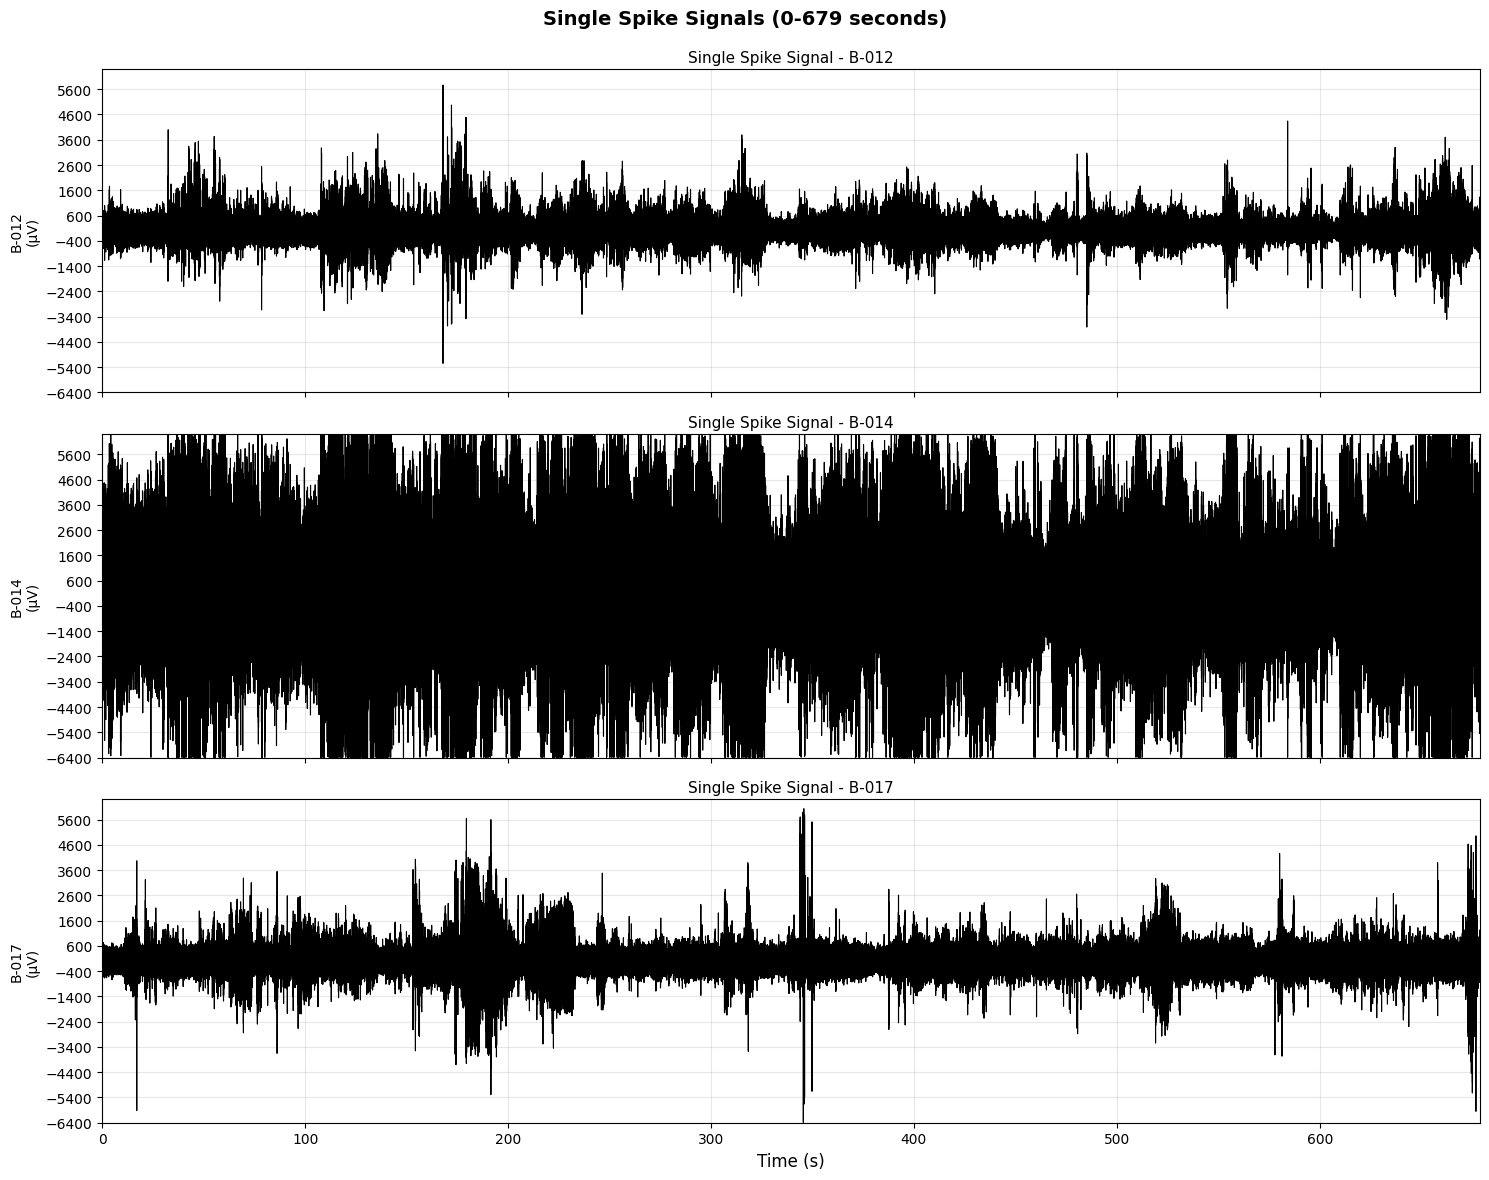

📊 Data Range Summary (0-679s):
   - Total samples: 13,580,001
   - Sampling rate: ~20000 Hz
   - Channels: ['B-012', 'B-014', 'B-017']


In [3]:
pt.simple_plot(df, start_time=0, end_time=679, figsize=(15, 12), spaceing=1000)

Estimated sampling rate: 20000.0 Hz
Applied highpass filter: 100 Hz
Applied highpass filter: 100 Hz
Removed DC offset from all channels
Removed DC offset from all channels


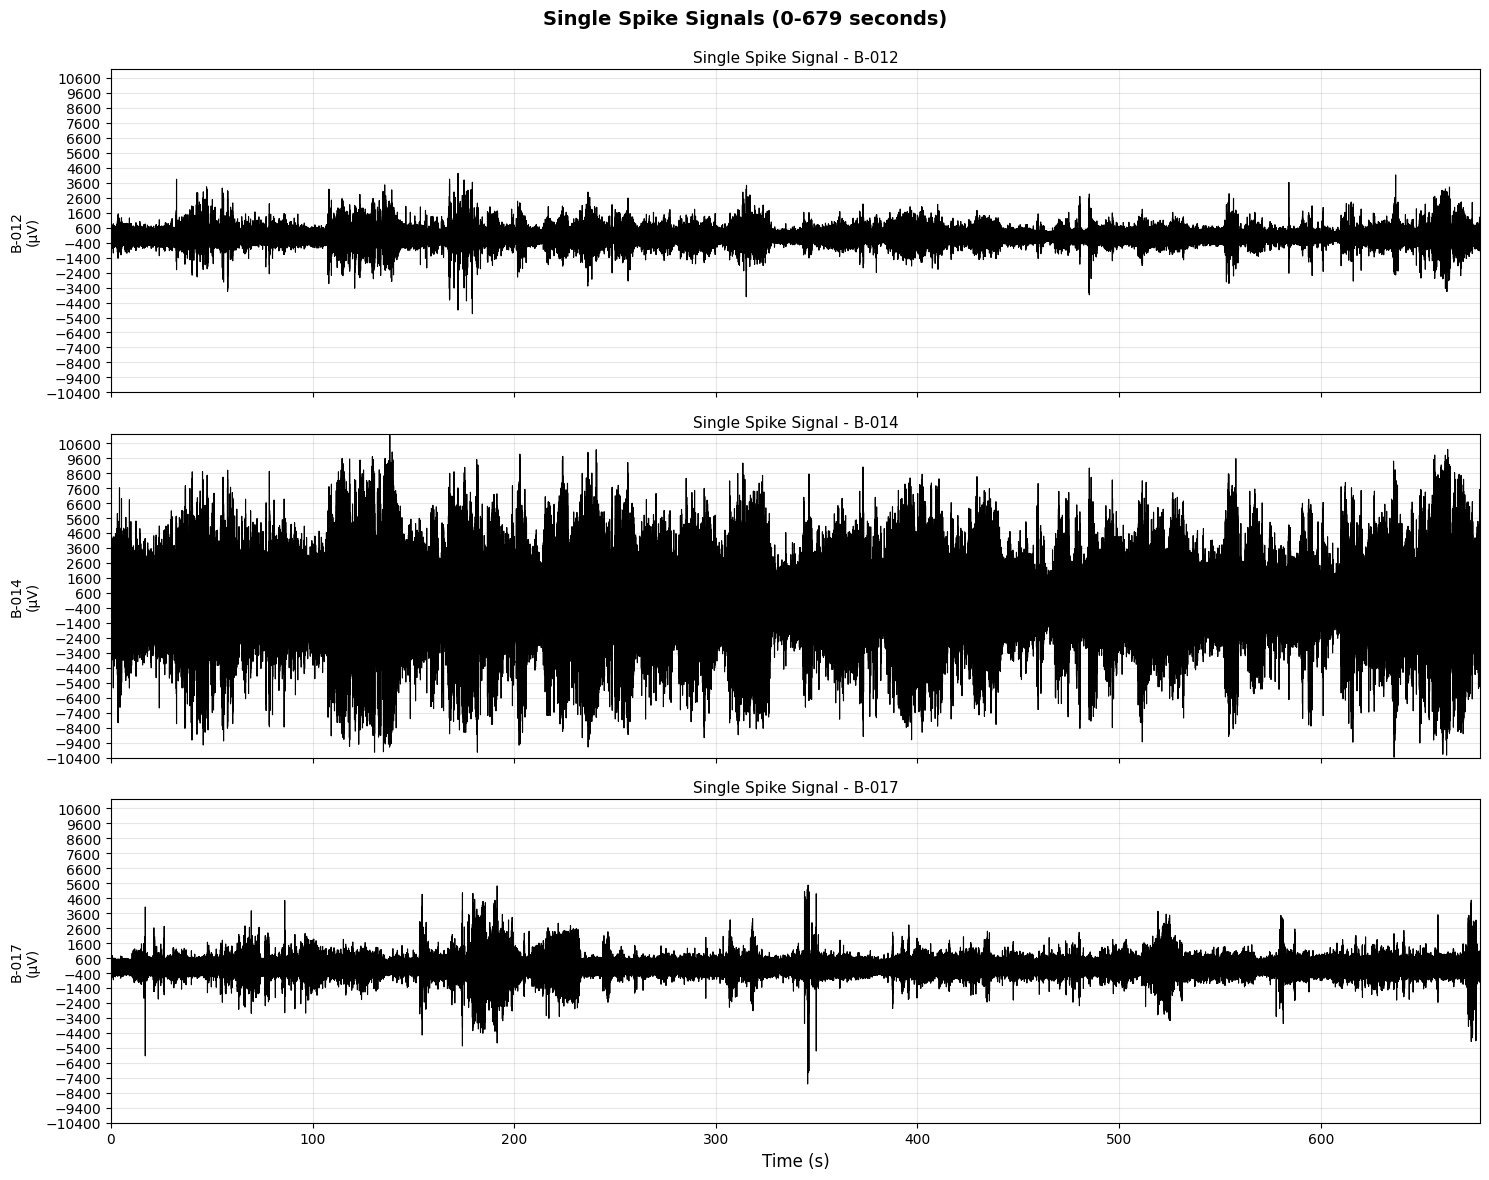

📊 Data Range Summary (0-679s):
   - Total samples: 13,580,001
   - Sampling rate: ~20000 Hz
   - Channels: ['B-012', 'B-014', 'B-017']


In [4]:
processed_df = spp.highpass_filter(df, cutoff=100)
processed_df = spp.remove_dc_offset(processed_df)
pt.simple_plot(processed_df, start_time=0, end_time=679, figsize=(15, 12), spaceing=1000)

# Amplitude Thresholding

Detected spikes in B-012: 47935


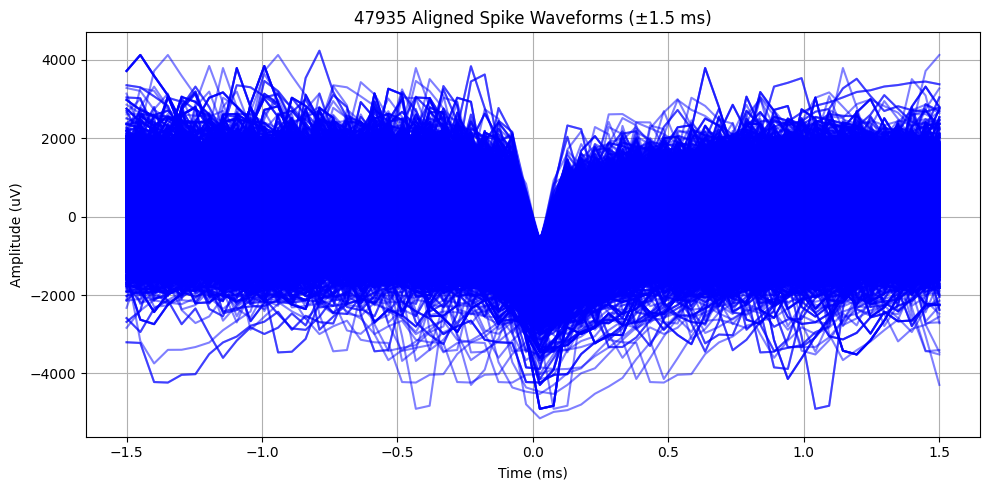

Detected spikes in B-014: 41053


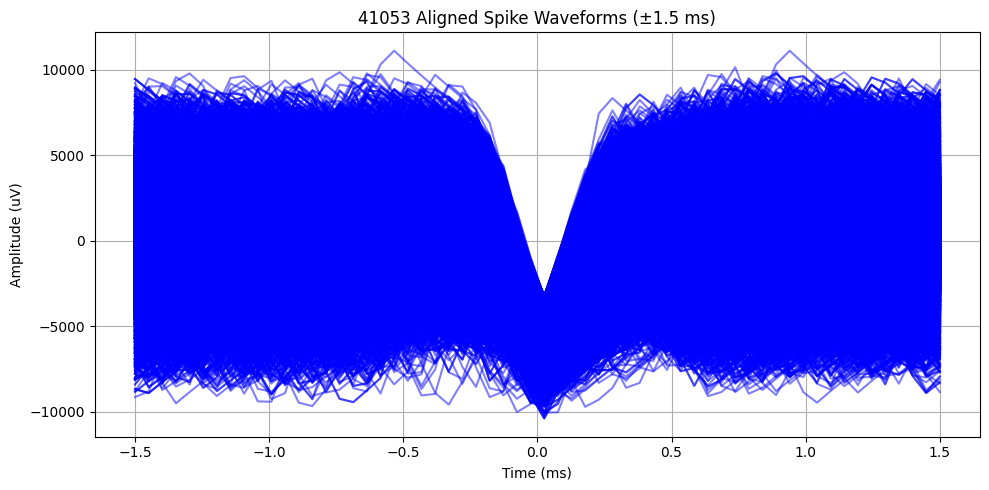

Detected spikes in B-017: 33826


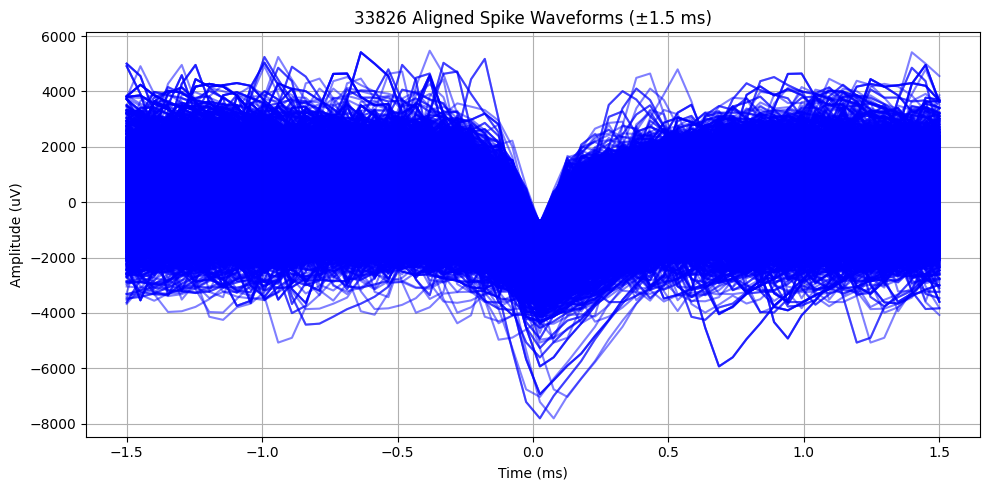

In [5]:
for column in processed_df.columns:
    if column != 'time':
        sig = processed_df[column]
        detector = SpikeDetector(sig, sampling_rate)
        detector.detect_by_snr(snr_threshold=4)
        print(f"Detected spikes in {column}: {len(detector.spike_indices)}")
        detector.plot_spike_waveforms(window_ms=3, max_waveforms=106955)

In [6]:
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
Memory: 12.0 GB


# Spike Data Collection and Feature Extraction

Collect all spike waveforms from all channels for PCA and clustering analysis.

In [15]:
# Collect all spike waveforms from all channels
all_spike_waveforms = []
channel_labels = []
spike_info = {}

window_ms = 5  # Same window as used in spike detection
window_samples = int(window_ms * sampling_rate / 1000)

print("Collecting spike waveforms from all channels...")

for column in processed_df.columns:
    if column != 'time':
        print(f"\nProcessing channel: {column}")
        sig = processed_df[column].values
        detector = SpikeDetector(sig, sampling_rate)
        detector.detect_by_snr(snr_threshold=10)
        
        n_spikes = len(detector.spike_indices)
        print(f"  - Found {n_spikes} spikes")
        
        if n_spikes > 0:
            # Extract spike waveforms
            spike_waveforms = []
            for spike_idx in detector.spike_indices:
                start_idx = max(0, spike_idx - window_samples // 2)
                end_idx = min(len(sig), spike_idx + window_samples // 2)
                
                # Ensure consistent waveform length
                if end_idx - start_idx == window_samples:
                    waveform = sig[start_idx:end_idx]
                    spike_waveforms.append(waveform)
            
            if spike_waveforms:
                spike_waveforms = np.array(spike_waveforms)
                all_spike_waveforms.append(spike_waveforms)
                channel_labels.extend([column] * len(spike_waveforms))
                spike_info[column] = {
                    'n_spikes': len(spike_waveforms),
                    'waveforms': spike_waveforms
                }
                print(f"  - Collected {len(spike_waveforms)} valid waveforms")

# Combine all waveforms into a single array
if all_spike_waveforms:
    all_waveforms_array = np.vstack(all_spike_waveforms)
    print(f"\nTotal collected waveforms: {all_waveforms_array.shape[0]}")
    print(f"Waveform length: {all_waveforms_array.shape[1]} samples ({window_ms}ms)")
    print(f"Channels with spikes: {list(spike_info.keys())}")
else:
    print("No spike waveforms collected!")
    all_waveforms_array = None


Processing channel: B-012
  - Found 2104 spikes
  - Collected 2104 valid waveforms

Processing channel: B-014
  - Found 2104 spikes
  - Collected 2104 valid waveforms

Processing channel: B-014
  - Found 374 spikes
  - Collected 374 valid waveforms

Processing channel: B-017
  - Found 374 spikes
  - Collected 374 valid waveforms

Processing channel: B-017
  - Found 2157 spikes
  - Collected 2157 valid waveforms

Total collected waveforms: 4635
Waveform length: 100 samples (5ms)
Channels with spikes: ['B-012', 'B-014', 'B-017']
  - Found 2157 spikes
  - Collected 2157 valid waveforms

Total collected waveforms: 4635
Waveform length: 100 samples (5ms)
Channels with spikes: ['B-012', 'B-014', 'B-017']


# Principal Component Analysis (PCA)

Perform PCA on the spike waveforms to reduce dimensionality and identify the main patterns.

Performing PCA analysis...
Data moved to cuda
Tensor shape: torch.Size([4635, 100])
PCA completed using 20 components
Explained variance by first 5 components: 0.499


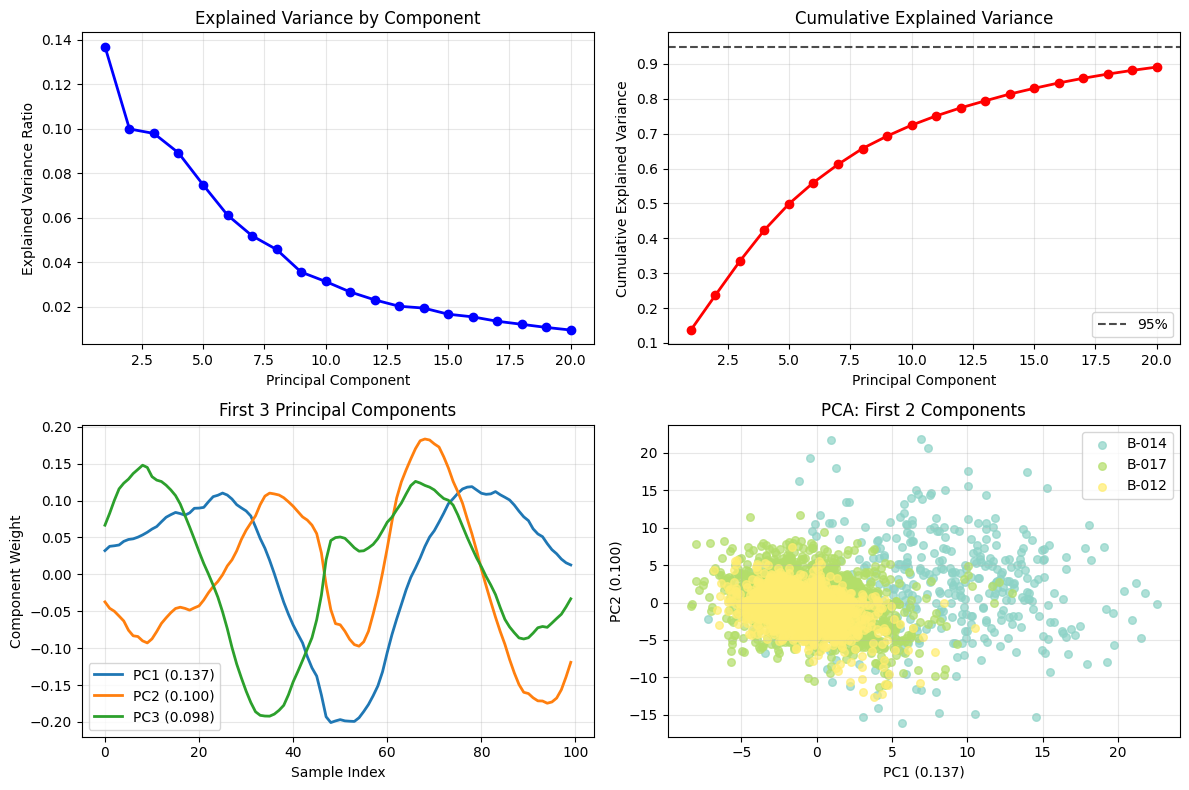

In [16]:
if all_waveforms_array is not None:
    print("Performing PCA analysis...")
    
    # Standardize the data
    scaler = StandardScaler()
    waveforms_scaled = scaler.fit_transform(all_waveforms_array)
    
    # Convert to PyTorch tensor and move to GPU
    waveforms_tensor = torch.tensor(waveforms_scaled, dtype=torch.float32).to(device)
    
    print(f"Data moved to {device}")
    print(f"Tensor shape: {waveforms_tensor.shape}")
    
    # Perform PCA using PyTorch (GPU accelerated)
    # Center the data
    mean = torch.mean(waveforms_tensor, dim=0, keepdim=True)
    centered_data = waveforms_tensor - mean
    
    # Compute covariance matrix
    cov_matrix = torch.mm(centered_data.T, centered_data) / (centered_data.shape[0] - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    # Sort by eigenvalues (descending)
    idx = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Compute explained variance ratio
    explained_variance_ratio = eigenvalues / torch.sum(eigenvalues)
    
    # Transform data to PC space
    n_components = min(20, waveforms_tensor.shape[1])  # Use up to 20 components
    pca_components = eigenvectors[:, :n_components]
    waveforms_pca = torch.mm(centered_data, pca_components)
    
    # Move results back to CPU for plotting
    explained_variance_ratio_cpu = explained_variance_ratio[:n_components].cpu().numpy()
    waveforms_pca_cpu = waveforms_pca.cpu().numpy()
    
    print(f"PCA completed using {n_components} components")
    print(f"Explained variance by first 5 components: {explained_variance_ratio_cpu[:5].sum():.3f}")
    
    # Plot explained variance
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(explained_variance_ratio_cpu) + 1), 
             explained_variance_ratio_cpu, 'bo-', linewidth=2, markersize=6)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    cumsum_var = np.cumsum(explained_variance_ratio_cpu)
    plt.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'ro-', linewidth=2, markersize=6)
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95%')
    plt.legend()
    
    # Plot first few principal components
    plt.subplot(2, 2, 3)
    for i in range(min(3, n_components)):
        pc = eigenvectors[:, i].cpu().numpy()
        plt.plot(pc, label=f'PC{i+1} ({explained_variance_ratio_cpu[i]:.3f})', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('Component Weight')
    plt.title('First 3 Principal Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2D PCA scatter
    plt.subplot(2, 2, 4)
    unique_channels = list(set(channel_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_channels)))
    
    for i, channel in enumerate(unique_channels):
        mask = np.array(channel_labels) == channel
        plt.scatter(waveforms_pca_cpu[mask, 0], waveforms_pca_cpu[mask, 1], 
                   c=[colors[i]], label=channel, alpha=0.7, s=30)
    
    plt.xlabel(f'PC1 ({explained_variance_ratio_cpu[0]:.3f})')
    plt.ylabel(f'PC2 ({explained_variance_ratio_cpu[1]:.3f})')
    plt.title('PCA: First 2 Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No waveform data available for PCA analysis!")

# K-means Clustering

Perform K-means clustering on the PCA-transformed spike data to identify distinct spike types.

Performing K-means clustering...
Using 10 PCA components for clustering
Data shape: torch.Size([4635, 10])
Finding optimal number of clusters...
Converged after 28 iterations
  k=2: inertia=294439.88
Converged after 40 iterations
  k=3: inertia=273555.38

 Using k=8 clusters
Converged after 51 iterations
Clustering completed!
Cluster distribution: [ 596 1253  104   77  443  166 1071  925]
Converged after 51 iterations
Clustering completed!
Cluster distribution: [ 596 1253  104   77  443  166 1071  925]


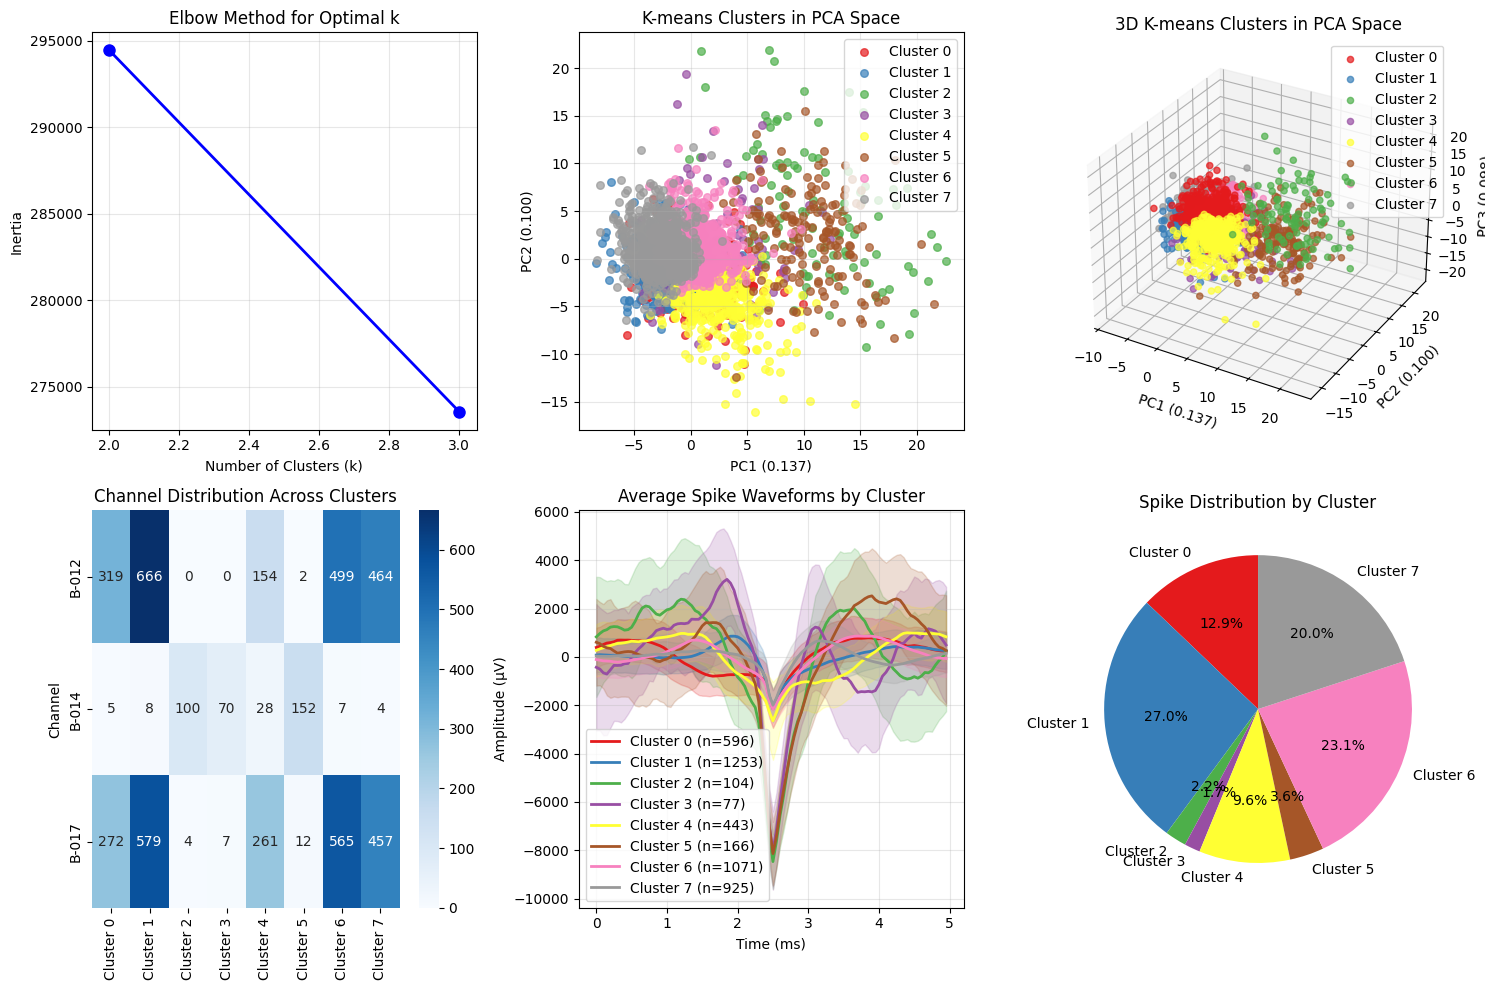


CLUSTERING RESULTS SUMMARY

 Cluster 0:
  - Number of spikes: 596
  - Percentage: 12.9%
  - Channels involved: ['B-014', 'B-017', 'B-012']
  - Number of channels: 3

 Cluster 1:
  - Number of spikes: 1253
  - Percentage: 27.0%
  - Channels involved: ['B-014', 'B-017', 'B-012']
  - Number of channels: 3

 Cluster 2:
  - Number of spikes: 104
  - Percentage: 2.2%
  - Channels involved: ['B-014', 'B-017']
  - Number of channels: 2

 Cluster 3:
  - Number of spikes: 77
  - Percentage: 1.7%
  - Channels involved: ['B-014', 'B-017']
  - Number of channels: 2

 Cluster 4:
  - Number of spikes: 443
  - Percentage: 9.6%
  - Channels involved: ['B-014', 'B-017', 'B-012']
  - Number of channels: 3

 Cluster 5:
  - Number of spikes: 166
  - Percentage: 3.6%
  - Channels involved: ['B-014', 'B-017', 'B-012']
  - Number of channels: 3

 Cluster 6:
  - Number of spikes: 1071
  - Percentage: 23.1%
  - Channels involved: ['B-014', 'B-017', 'B-012']
  - Number of channels: 3

 Cluster 7:
  - Number of 

In [17]:
# GPU-accelerated K-means clustering implementation
class TorchKMeans:
    def __init__(self, n_clusters, max_iters=100, tol=1e-4, device='cuda'):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.device = device
        
    def fit(self, X):
        # Initialize centroids randomly
        n_samples, n_features = X.shape
        self.centroids = X[torch.randperm(n_samples)[:self.n_clusters]].clone()
        
        prev_centroids = self.centroids.clone()
        
        for iter_num in range(self.max_iters):
            # Assign points to closest centroid
            distances = torch.cdist(X, self.centroids)
            self.labels = torch.argmin(distances, dim=1)
            
            # Update centroids
            new_centroids = torch.zeros_like(self.centroids)
            for k in range(self.n_clusters):
                mask = self.labels == k
                if mask.sum() > 0:
                    new_centroids[k] = X[mask].mean(dim=0)
                else:
                    new_centroids[k] = self.centroids[k]
            
            # Check for convergence
            centroid_shift = torch.norm(new_centroids - self.centroids, dim=1).max()
            self.centroids = new_centroids
            
            if centroid_shift < self.tol:
                print(f"Converged after {iter_num + 1} iterations")
                break
        
        # Calculate inertia (within-cluster sum of squares)
        distances_to_centroids = torch.gather(distances, 1, self.labels.unsqueeze(1))
        self.inertia = torch.sum(distances_to_centroids ** 2).item()
        
        return self
    
    def predict(self, X):
        distances = torch.cdist(X, self.centroids)
        return torch.argmin(distances, dim=1)

if all_waveforms_array is not None and 'waveforms_pca' in locals():
    print("Performing K-means clustering...")
    
    # Use first few PCA components for clustering
    n_pca_features = min(10, waveforms_pca.shape[1])
    pca_features = waveforms_pca[:, :n_pca_features]
    
    print(f"Using {n_pca_features} PCA components for clustering")
    print(f"Data shape: {pca_features.shape}")
    
    # Determine optimal number of clusters using elbow method
    max_clusters = min(10, len(set(channel_labels)))
    inertias = []
    K_range = range(2, max_clusters + 1)
    
    print("Finding optimal number of clusters...")
    for k in K_range:
        kmeans = TorchKMeans(n_clusters=k, device=device)
        kmeans.fit(pca_features)
        inertias.append(kmeans.inertia)
        print(f"  k={k}: inertia={kmeans.inertia:.2f}")
    
    # Plot elbow curve
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    
    # Choose optimal k (you can adjust this)
    optimal_k = 8  # or use elbow method result
    print(f"\n Using k={optimal_k} clusters")
    
    # Final clustering with optimal k
    final_kmeans = TorchKMeans(n_clusters=optimal_k, device=device)
    final_kmeans.fit(pca_features)
    cluster_labels = final_kmeans.labels.cpu().numpy()
    
    print(f"Clustering completed!")
    print(f"Cluster distribution: {np.bincount(cluster_labels)}")
    
    # Visualize clustering results
    # 2D PCA plot with clusters
    plt.subplot(2, 3, 2)
    colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
    for k in range(optimal_k):
        mask = cluster_labels == k
        plt.scatter(waveforms_pca_cpu[mask, 0], waveforms_pca_cpu[mask, 1], 
                   c=[colors[k]], label=f'Cluster {k}', alpha=0.7, s=30)
    
    plt.xlabel(f'PC1 ({explained_variance_ratio_cpu[0]:.3f})')
    plt.ylabel(f'PC2 ({explained_variance_ratio_cpu[1]:.3f})')
    plt.title('K-means Clusters in PCA Space')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3D PCA plot with clusters
    ax = plt.subplot(2, 3, 3, projection='3d')
    for k in range(optimal_k):
        mask = cluster_labels == k
        ax.scatter(waveforms_pca_cpu[mask, 0], waveforms_pca_cpu[mask, 1], 
                  waveforms_pca_cpu[mask, 2], c=[colors[k]], label=f'Cluster {k}', 
                  alpha=0.7, s=20)
    
    ax.set_xlabel(f'PC1 ({explained_variance_ratio_cpu[0]:.3f})')
    ax.set_ylabel(f'PC2 ({explained_variance_ratio_cpu[1]:.3f})')
    ax.set_zlabel(f'PC3 ({explained_variance_ratio_cpu[2]:.3f})')
    ax.set_title('3D K-means Clusters in PCA Space')
    ax.legend()
    
    # Channel distribution per cluster
    plt.subplot(2, 3, 4)
    channel_cluster_matrix = np.zeros((len(set(channel_labels)), optimal_k))
    unique_channels = sorted(set(channel_labels))
    
    for i, channel in enumerate(unique_channels):
        channel_mask = np.array(channel_labels) == channel
        for k in range(optimal_k):
            cluster_mask = cluster_labels == k
            channel_cluster_matrix[i, k] = np.sum(channel_mask & cluster_mask)
    
    sns.heatmap(channel_cluster_matrix, 
                xticklabels=[f'Cluster {k}' for k in range(optimal_k)],
                yticklabels=unique_channels,
                annot=True, fmt='g', cmap='Blues')
    plt.title('Channel Distribution Across Clusters')
    plt.ylabel('Channel')
    
    # Average waveforms per cluster
    plt.subplot(2, 3, 5)
    time_axis = np.arange(all_waveforms_array.shape[1]) / sampling_rate * 1000  # Convert to ms
    
    for k in range(optimal_k):
        mask = cluster_labels == k
        if np.sum(mask) > 0:
            avg_waveform = np.mean(all_waveforms_array[mask], axis=0)
            std_waveform = np.std(all_waveforms_array[mask], axis=0)
            plt.plot(time_axis, avg_waveform, color=colors[k], 
                    linewidth=2, label=f'Cluster {k} (n={np.sum(mask)})')
            plt.fill_between(time_axis, avg_waveform - std_waveform, 
                           avg_waveform + std_waveform, 
                           color=colors[k], alpha=0.2)
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.title('Average Spike Waveforms by Cluster')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Cluster statistics
    plt.subplot(2, 3, 6)
    cluster_stats = []
    for k in range(optimal_k):
        mask = cluster_labels == k
        n_spikes = np.sum(mask)
        channels_in_cluster = set(np.array(channel_labels)[mask])
        cluster_stats.append({
            'cluster': k,
            'n_spikes': n_spikes,
            'channels': len(channels_in_cluster),
            'percentage': n_spikes / len(cluster_labels) * 100
        })
    
    clusters = [stat['cluster'] for stat in cluster_stats]
    percentages = [stat['percentage'] for stat in cluster_stats]
    
    plt.pie(percentages, labels=[f'Cluster {k}' for k in clusters], 
            colors=colors[:optimal_k], autopct='%1.1f%%', startangle=90)
    plt.title('Spike Distribution by Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*50)
    print("CLUSTERING RESULTS SUMMARY")
    print("="*50)
    for stat in cluster_stats:
        k = stat['cluster']
        mask = cluster_labels == k
        channels_in_cluster = list(set(np.array(channel_labels)[mask]))
        print(f"\n Cluster {k}:")
        print(f"  - Number of spikes: {stat['n_spikes']}")
        print(f"  - Percentage: {stat['percentage']:.1f}%")
        print(f"  - Channels involved: {channels_in_cluster}")
        print(f"  - Number of channels: {len(channels_in_cluster)}")
    
else:
    print("PCA results not available for clustering!")

# Spike Raster Plot

Create a raster plot showing detected spikes across all channels over the entire recording time frame.

Processing channel 1/3: B-012
  - Found 47935 spikes
Processing channel 2/3: B-014
  - Found 47935 spikes
Processing channel 2/3: B-014
  - Found 41053 spikes
Processing channel 3/3: B-017
  - Found 41053 spikes
Processing channel 3/3: B-017
  - Found 33826 spikes

Total spikes detected: 122814
Time range: 0.0 - 679.5 seconds
  - Found 33826 spikes

Total spikes detected: 122814
Time range: 0.0 - 679.5 seconds


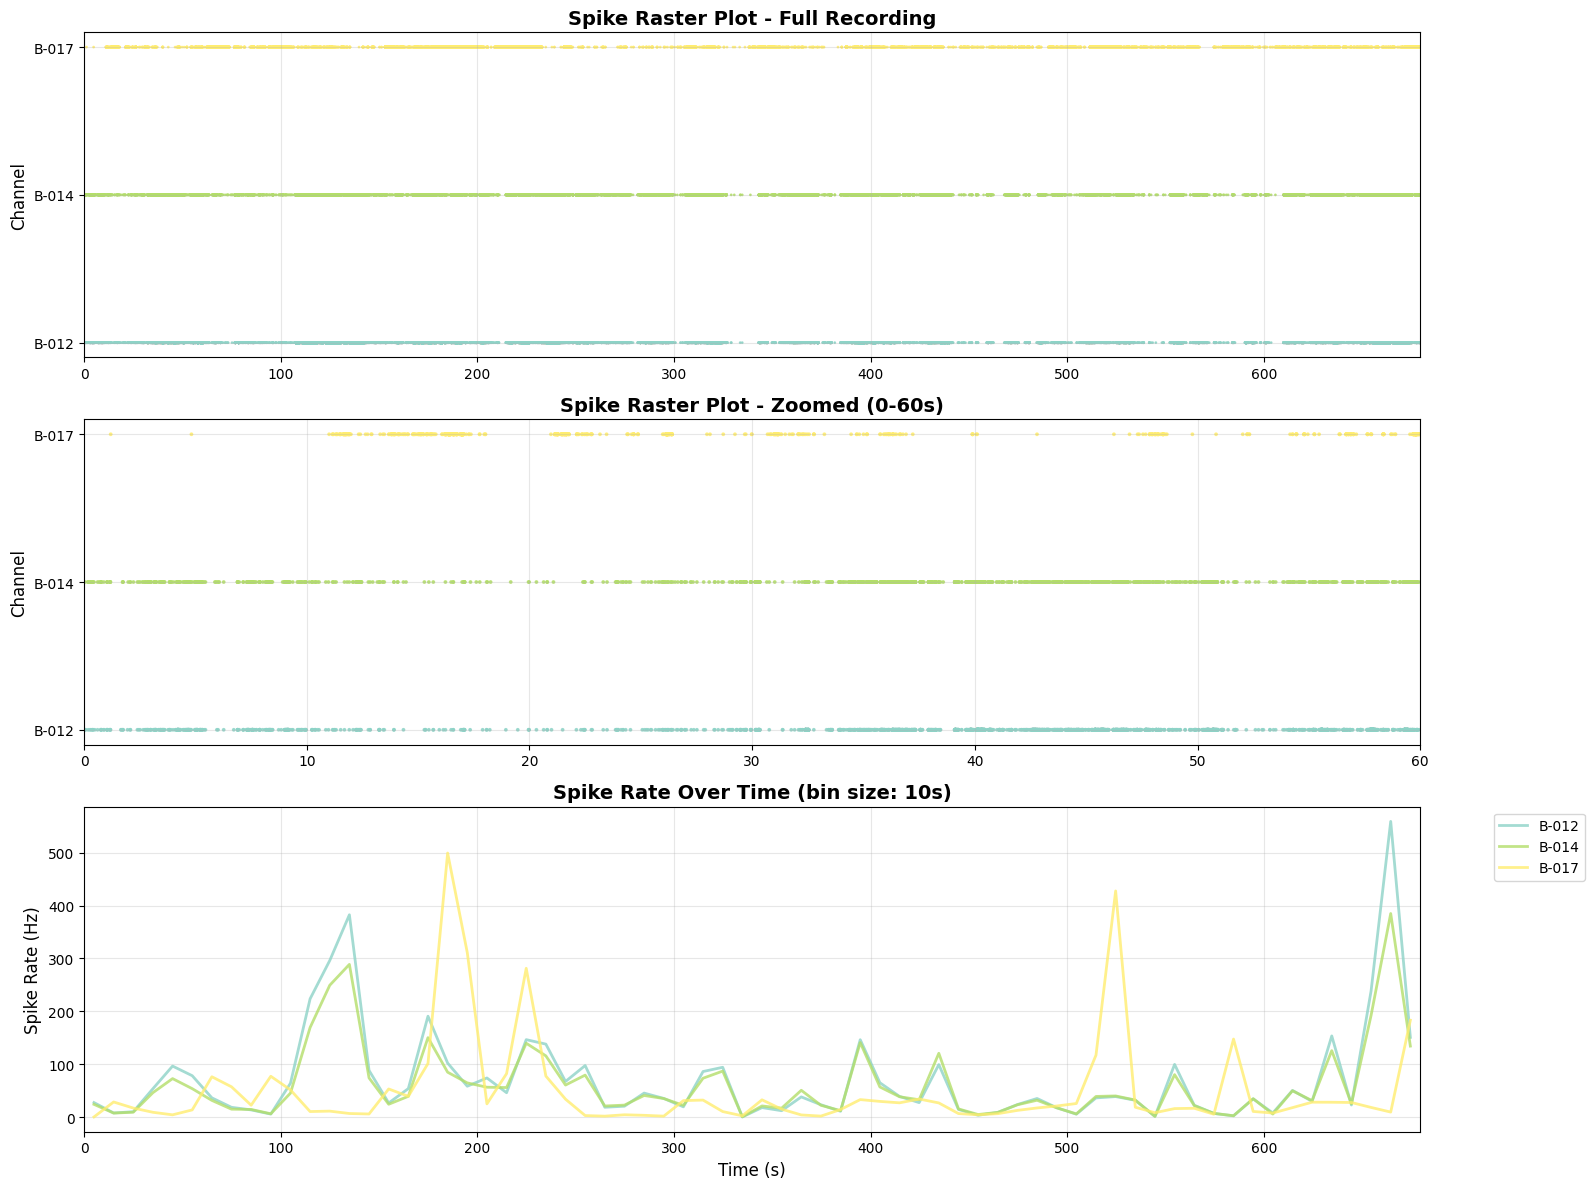


SPIKE RASTER PLOT SUMMARY

B-012:
  - Total spikes: 47935
  - Average spike rate: 70.54 Hz
  - Mean ISI: 0.014 ± 0.102 s
  - ISI range: 0.000 - 8.343 s

B-014:
  - Total spikes: 41053
  - Average spike rate: 60.42 Hz
  - Mean ISI: 0.017 ± 0.096 s
  - ISI range: 0.000 - 5.572 s

B-017:
  - Total spikes: 33826
  - Average spike rate: 49.78 Hz
  - Mean ISI: 0.020 ± 0.137 s
  - ISI range: 0.000 - 7.313 s

Overall Statistics:
  - Total recording time: 679.5 seconds
  - Total spikes (all channels): 122814
  - Overall spike rate: 180.74 Hz
  - Active channels: 3/3


In [18]:
# Collect spike times for all channels
print("Collecting spike times for raster plot...")

spike_times_by_channel = {}
all_spike_times = []
channel_names = []

# Extract pin columns (exclude 'time')
pin_columns = [col for col in processed_df.columns if col != 'time']

for i, column in enumerate(pin_columns):
    print(f"Processing channel {i+1}/{len(pin_columns)}: {column}")
    
    # Get signal data
    sig = processed_df[column].values
    time_values = processed_df['time'].values
    
    # Detect spikes
    detector = SpikeDetector(sig, sampling_rate)
    detector.detect_by_snr(snr_threshold=4)  # Using same threshold as before
    
    # Convert spike indices to time values
    spike_times = time_values[detector.spike_indices]
    spike_times_by_channel[column] = spike_times
    
    print(f"  - Found {len(spike_times)} spikes")
    
    # Store for raster plot
    all_spike_times.extend(spike_times)
    channel_names.extend([column] * len(spike_times))

print(f"\nTotal spikes detected: {len(all_spike_times)}")
print(f"Time range: {processed_df['time'].min():.1f} - {processed_df['time'].max():.1f} seconds")

# Create raster plot
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Full time range raster plot
ax1 = axes[0]
y_positions = []
spike_times_plot = []
colors_plot = []

# Assign colors to channels
channel_colors = plt.cm.Set3(np.linspace(0, 1, len(pin_columns)))

for i, channel in enumerate(pin_columns):
    spike_times = spike_times_by_channel[channel]
    if len(spike_times) > 0:
        y_positions.extend([i] * len(spike_times))
        spike_times_plot.extend(spike_times)
        colors_plot.extend([channel_colors[i]] * len(spike_times))

if spike_times_plot:
    ax1.scatter(spike_times_plot, y_positions, c=colors_plot, s=1, alpha=0.8)

ax1.set_ylabel('Channel', fontsize=12)
ax1.set_title('Spike Raster Plot - Full Recording', fontsize=14, fontweight='bold')
ax1.set_yticks(range(len(pin_columns)))
ax1.set_yticklabels(pin_columns)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(processed_df['time'].min(), processed_df['time'].max())

# 2. Zoomed raster plot (first 60 seconds)
ax2 = axes[1]
zoom_end = min(60, processed_df['time'].max())
y_positions_zoom = []
spike_times_zoom = []
colors_zoom = []

for i, channel in enumerate(pin_columns):
    spike_times = spike_times_by_channel[channel]
    # Filter spikes in zoom range
    zoom_spikes = spike_times[(spike_times >= 0) & (spike_times <= zoom_end)]
    if len(zoom_spikes) > 0:
        y_positions_zoom.extend([i] * len(zoom_spikes))
        spike_times_zoom.extend(zoom_spikes)
        colors_zoom.extend([channel_colors[i]] * len(zoom_spikes))

if spike_times_zoom:
    ax2.scatter(spike_times_zoom, y_positions_zoom, c=colors_zoom, s=3, alpha=0.8)

ax2.set_ylabel('Channel', fontsize=12)
ax2.set_title(f'Spike Raster Plot - Zoomed (0-{zoom_end}s)', fontsize=14, fontweight='bold')
ax2.set_yticks(range(len(pin_columns)))
ax2.set_yticklabels(pin_columns)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, zoom_end)

# 3. Spike rate over time (binned)
ax3 = axes[2]
bin_size = 10  # 10 second bins
time_max = processed_df['time'].max()
n_bins = int(np.ceil(time_max / bin_size))
time_bins = np.linspace(0, time_max, n_bins + 1)

for i, channel in enumerate(pin_columns):
    spike_times = spike_times_by_channel[channel]
    if len(spike_times) > 0:
        # Count spikes in each bin
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        spike_rate = spike_counts / bin_size  # Convert to spikes per second
        
        # Plot as line
        bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
        ax3.plot(bin_centers, spike_rate, color=channel_colors[i], 
                linewidth=2, label=f'{channel}', alpha=0.8)

ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Spike Rate (Hz)', fontsize=12)
ax3.set_title(f'Spike Rate Over Time (bin size: {bin_size}s)', fontsize=14, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, time_max)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SPIKE RASTER PLOT SUMMARY")
print("="*60)

total_recording_time = processed_df['time'].max() - processed_df['time'].min()

for i, channel in enumerate(pin_columns):
    spike_times = spike_times_by_channel[channel]
    n_spikes = len(spike_times)
    spike_rate = n_spikes / total_recording_time if total_recording_time > 0 else 0
    
    print(f"\n{channel}:")
    print(f"  - Total spikes: {n_spikes}")
    print(f"  - Average spike rate: {spike_rate:.2f} Hz")
    if n_spikes > 1:
        isi = np.diff(spike_times)  # Inter-spike intervals
        print(f"  - Mean ISI: {np.mean(isi):.3f} ± {np.std(isi):.3f} s")
        print(f"  - ISI range: {np.min(isi):.3f} - {np.max(isi):.3f} s")

print(f"\nOverall Statistics:")
print(f"  - Total recording time: {total_recording_time:.1f} seconds")
print(f"  - Total spikes (all channels): {len(all_spike_times)}")
print(f"  - Overall spike rate: {len(all_spike_times)/total_recording_time:.2f} Hz")
print(f"  - Active channels: {len([ch for ch in pin_columns if len(spike_times_by_channel[ch]) > 0])}/{len(pin_columns)}")

Plotting detailed raster plot for first 30 seconds...


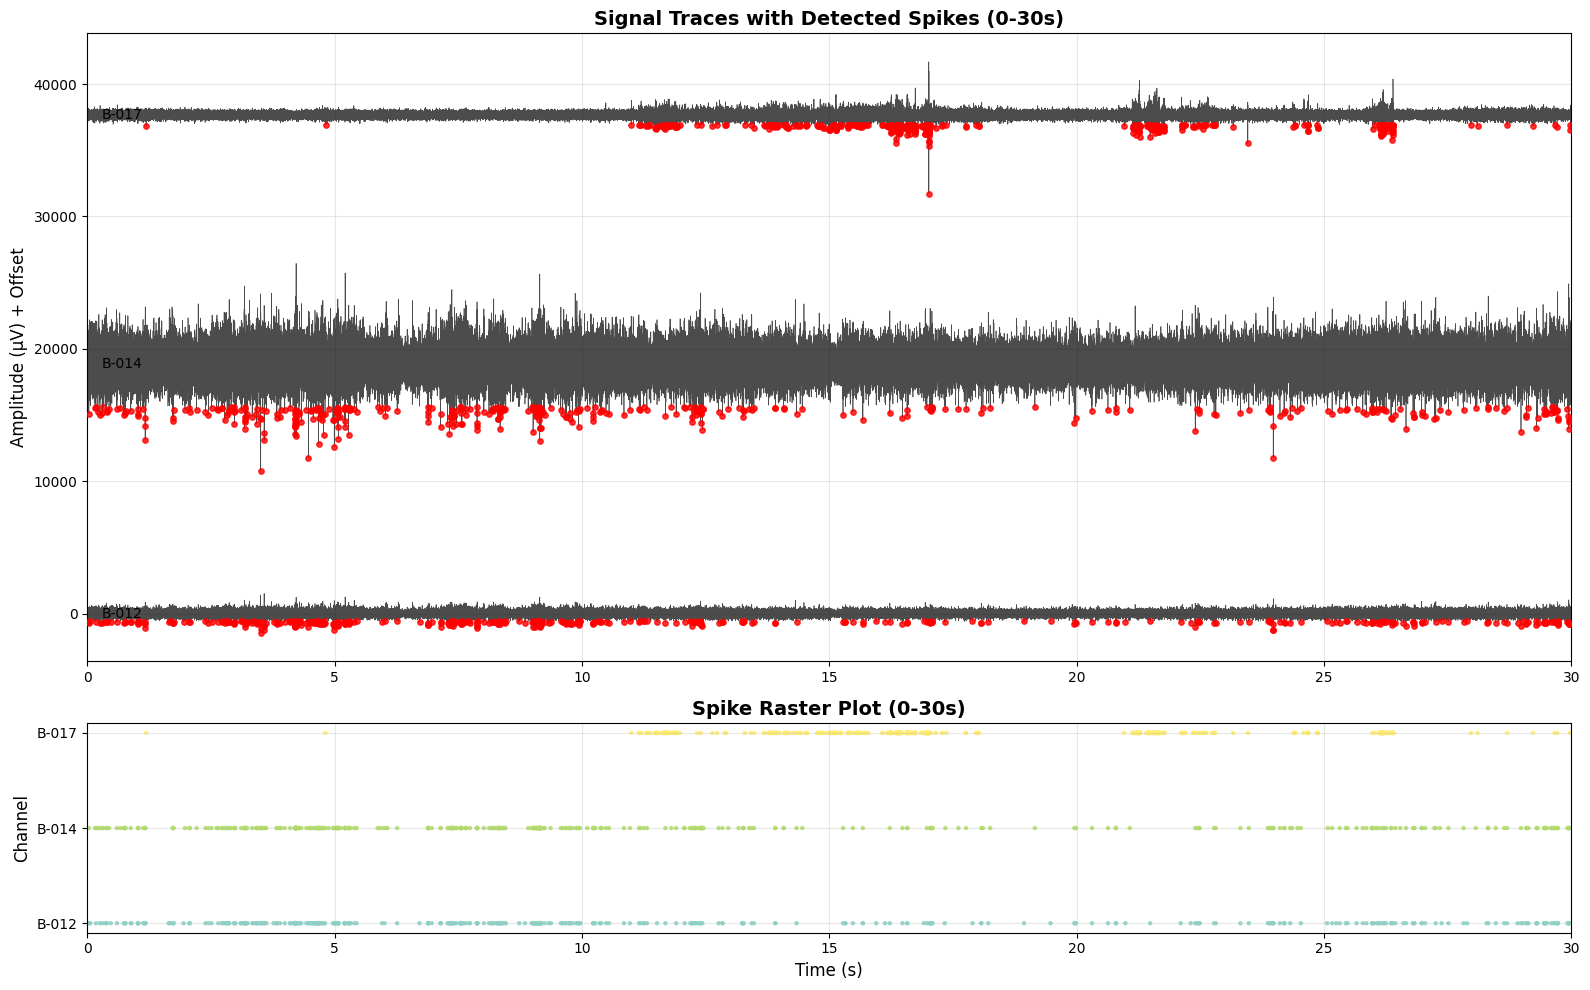


Window Statistics (0-30s):
  - Duration: 30.0 seconds
  - Total spikes: 1317
  - Spike rate: 43.90 Hz
  - B-012: 452 spikes (15.07 Hz)
  - B-014: 406 spikes (13.53 Hz)
  - B-017: 459 spikes (15.30 Hz)


In [19]:
# Interactive raster plot function for custom time windows
def plot_raster_window(start_time=0, end_time=60, spike_size=3, show_signal=True):
    """
    Plot raster plot for a specific time window with optional signal overlay
    
    Parameters:
    -----------
    start_time : float
        Start time in seconds
    end_time : float
        End time in seconds
    spike_size : int
        Size of spike markers
    show_signal : bool
        Whether to show the actual signal traces
    """
    
    # Filter time range
    time_mask = (processed_df['time'] >= start_time) & (processed_df['time'] <= end_time)
    windowed_data = processed_df[time_mask].copy()
    
    if len(windowed_data) == 0:
        print(f"No data in time window {start_time}-{end_time} seconds")
        return
    
    n_channels = len(pin_columns)
    
    if show_signal:
        # Create subplot with signal traces and raster plot
        fig, axes = plt.subplots(2, 1, figsize=(16, 10), 
                                gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot signal traces
        ax_signal = axes[0]
        
        # Calculate offset for each channel to separate traces
        all_data = []
        for col in pin_columns:
            all_data.extend(windowed_data[col].values)
        
        signal_range = np.max(all_data) - np.min(all_data)
        offset_step = signal_range * 1.2  # 20% spacing between channels
        
        for i, channel in enumerate(pin_columns):
            offset = i * offset_step
            signal_data = windowed_data[channel].values + offset
            ax_signal.plot(windowed_data['time'], signal_data, 
                          color='black', linewidth=0.5, alpha=0.7)
            
            # Add channel label
            ax_signal.text(start_time + (end_time - start_time) * 0.01, 
                          offset, channel, fontsize=10, 
                          verticalalignment='center')
            
            # Mark spikes on signal
            channel_spikes = spike_times_by_channel[channel]
            window_spikes = channel_spikes[(channel_spikes >= start_time) & 
                                         (channel_spikes <= end_time)]
            
            if len(window_spikes) > 0:
                # Get spike amplitudes
                spike_amplitudes = []
                for spike_time in window_spikes:
                    # Find closest time index
                    time_idx = np.argmin(np.abs(windowed_data['time'] - spike_time))
                    spike_amp = windowed_data[channel].iloc[time_idx] + offset
                    spike_amplitudes.append(spike_amp)
                
                ax_signal.scatter(window_spikes, spike_amplitudes, 
                                color='red', s=spike_size*3, alpha=0.8, 
                                zorder=5, marker='o')
        
        ax_signal.set_ylabel('Amplitude (µV) + Offset', fontsize=12)
        ax_signal.set_title(f'Signal Traces with Detected Spikes ({start_time}-{end_time}s)', 
                           fontsize=14, fontweight='bold')
        ax_signal.grid(True, alpha=0.3)
        ax_signal.set_xlim(start_time, end_time)
        
        # Raster plot
        ax_raster = axes[1]
    else:
        # Only raster plot
        fig, ax_raster = plt.subplots(1, 1, figsize=(16, 6))
    
    # Create raster plot
    y_positions = []
    spike_times_plot = []
    colors_plot = []
    
    for i, channel in enumerate(pin_columns):
        channel_spikes = spike_times_by_channel[channel]
        window_spikes = channel_spikes[(channel_spikes >= start_time) & 
                                     (channel_spikes <= end_time)]
        
        if len(window_spikes) > 0:
            y_positions.extend([i] * len(window_spikes))
            spike_times_plot.extend(window_spikes)
            colors_plot.extend([channel_colors[i]] * len(window_spikes))
    
    if spike_times_plot:
        ax_raster.scatter(spike_times_plot, y_positions, 
                         c=colors_plot, s=spike_size, alpha=0.8)
    
    ax_raster.set_xlabel('Time (s)', fontsize=12)
    ax_raster.set_ylabel('Channel', fontsize=12)
    ax_raster.set_title(f'Spike Raster Plot ({start_time}-{end_time}s)', 
                       fontsize=14, fontweight='bold')
    ax_raster.set_yticks(range(len(pin_columns)))
    ax_raster.set_yticklabels(pin_columns)
    ax_raster.grid(True, alpha=0.3)
    ax_raster.set_xlim(start_time, end_time)
    
    plt.tight_layout()
    plt.show()
    
    # Print window statistics
    total_spikes_in_window = len(spike_times_plot)
    window_duration = end_time - start_time
    
    print(f"\nWindow Statistics ({start_time}-{end_time}s):")
    print(f"  - Duration: {window_duration:.1f} seconds")
    print(f"  - Total spikes: {total_spikes_in_window}")
    print(f"  - Spike rate: {total_spikes_in_window/window_duration:.2f} Hz")
    
    # Per-channel statistics in window
    for channel in pin_columns:
        channel_spikes = spike_times_by_channel[channel]
        window_spikes = channel_spikes[(channel_spikes >= start_time) & 
                                     (channel_spikes <= end_time)]
        if len(window_spikes) > 0:
            rate = len(window_spikes) / window_duration
            print(f"  - {channel}: {len(window_spikes)} spikes ({rate:.2f} Hz)")

# Example usage - plot first 30 seconds with signal overlay
print("Plotting detailed raster plot for first 30 seconds...")
plot_raster_window(start_time=0, end_time=30, spike_size=5, show_signal=True)

In [20]:
# # Optimized raster plot examples and analysis

# print("Creating optimized raster plot visualizations...")

# # 1. Raster plot with cluster colors (if clustering was performed)
# if 'cluster_labels' in locals() and cluster_labels is not None:
#     print("\n1. Raster plot colored by spike clusters...")
    
#     fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
#     # Map each spike to its cluster (optimized)
#     spike_cluster_map = {}
#     spike_idx = 0
    
#     # Create mapping more efficiently
#     all_spike_times_ordered = []
#     for channel in pin_columns:
#         channel_spikes = spike_times_by_channel[channel]
#         all_spike_times_ordered.extend([(t, channel) for t in channel_spikes])
    
#     # Sort by time to match cluster labels order
#     all_spike_times_ordered.sort(key=lambda x: x[0])
    
#     for i, (spike_time, channel) in enumerate(all_spike_times_ordered):
#         if i < len(cluster_labels):
#             spike_cluster_map[spike_time] = cluster_labels[i]
    
#     # Plot spikes colored by cluster
#     cluster_colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
    
#     for i, channel in enumerate(pin_columns):
#         channel_spikes = spike_times_by_channel[channel]
        
#         for spike_time in channel_spikes:
#             if spike_time in spike_cluster_map:
#                 cluster_id = spike_cluster_map[spike_time]
#                 color = cluster_colors[cluster_id]
#                 ax.scatter(spike_time, i, c=[color], s=3, alpha=0.8)
    
#     ax.set_xlabel('Time (s)', fontsize=12)
#     ax.set_ylabel('Channel', fontsize=12)
#     ax.set_title('Spike Raster Plot - Colored by Cluster', fontsize=14, fontweight='bold')
#     ax.set_yticks(range(len(pin_columns)))
#     ax.set_yticklabels(pin_columns)
#     ax.grid(True, alpha=0.3)
    
#     # Add cluster legend
#     legend_elements = [plt.scatter([], [], c=[cluster_colors[k]], s=50, 
#                                   label=f'Cluster {k}') for k in range(optimal_k)]
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
#     plt.tight_layout()
#     plt.show()

# # 2. Optimized PSTH-style binned spike rate analysis
# print("\n2. Creating PSTH-style binned spike rate analysis...")

# bin_sizes = [1.0, 5.0]  # Reduced bin sizes for faster computation
# fig, axes = plt.subplots(len(bin_sizes), 1, figsize=(16, 4*len(bin_sizes)))

# if len(bin_sizes) == 1:
#     axes = [axes]

# for idx, bin_size in enumerate(bin_sizes):
#     ax = axes[idx]
    
#     time_max = processed_df['time'].max()
#     n_bins = int(np.ceil(time_max / bin_size))
#     time_bins = np.linspace(0, time_max, n_bins + 1)
#     bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
    
#     # Stack plot for all channels
#     bottom = np.zeros(len(bin_centers))
    
#     for i, channel in enumerate(pin_columns):
#         spike_times = spike_times_by_channel[channel]
#         if len(spike_times) > 0:
#             spike_counts, _ = np.histogram(spike_times, bins=time_bins)
#             spike_rate = spike_counts / bin_size  # Convert to Hz
            
#             ax.fill_between(bin_centers, bottom, bottom + spike_rate, 
#                            color=channel_colors[i], alpha=0.7, label=channel)
#             bottom += spike_rate
    
#     ax.set_xlabel('Time (s)', fontsize=12)
#     ax.set_ylabel('Spike Rate (Hz)', fontsize=12)
#     ax.set_title(f'Stacked Spike Rate (bin size: {bin_size}s)', fontsize=13, fontweight='bold')
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     ax.grid(True, alpha=0.3)
#     ax.set_xlim(0, time_max)

# plt.tight_layout()
# plt.show()

# # 3. Simplified cross-correlation analysis between channels
# print("\n3. Simplified spike cross-correlation analysis...")

# if len(pin_columns) >= 2:
#     from scipy.stats import pearsonr
    
#     # Use larger time bins for efficiency (10ms resolution instead of 1ms)
#     dt = 0.01  # 10ms resolution (10x faster)
#     t_max = processed_df['time'].max()
#     time_bins = np.arange(0, t_max, dt)
    
#     print(f"Using {dt*1000:.0f}ms resolution for correlation analysis...")
#     print(f"Creating {len(time_bins)} time bins...")
    
#     spike_trains = {}
#     for channel in pin_columns:
#         spike_times = spike_times_by_channel[channel]
#         spike_train = np.zeros(len(time_bins) - 1)
        
#         if len(spike_times) > 0:
#             spike_indices = np.digitize(spike_times, time_bins) - 1
#             spike_indices = spike_indices[(spike_indices >= 0) & 
#                                         (spike_indices < len(spike_train))]
#             # Count spikes in each bin (allows multiple spikes per bin)
#             for idx in spike_indices:
#                 spike_train[idx] += 1
        
#         spike_trains[channel] = spike_train
    
#     # Compute cross-correlation matrix
#     n_channels = len(pin_columns)
#     correlation_matrix = np.zeros((n_channels, n_channels))
    
#     print("Computing correlations...")
#     for i, ch1 in enumerate(pin_columns):
#         for j, ch2 in enumerate(pin_columns):
#             if len(spike_trains[ch1]) > 0 and len(spike_trains[ch2]) > 0:
#                 # Use numpy's corrcoef for faster computation
#                 if np.std(spike_trains[ch1]) > 0 and np.std(spike_trains[ch2]) > 0:
#                     corr_matrix = np.corrcoef(spike_trains[ch1], spike_trains[ch2])
#                     correlation_matrix[i, j] = corr_matrix[0, 1]
#                 else:
#                     correlation_matrix[i, j] = 0
#             else:
#                 correlation_matrix[i, j] = 0
    
#     # Plot correlation matrix
#     fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#     im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
#     ax.set_xticks(range(n_channels))
#     ax.set_yticks(range(n_channels))
#     ax.set_xticklabels(pin_columns, rotation=45)
#     ax.set_yticklabels(pin_columns)
    
#     # Add correlation values as text
#     for i in range(n_channels):
#         for j in range(n_channels):
#             ax.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
#                    ha='center', va='center', 
#                    color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')
    
#     ax.set_title(f'Spike Train Cross-Correlation Matrix\\n(Resolution: {dt*1000:.0f}ms)', 
#                 fontsize=14, fontweight='bold')
    
#     # Add colorbar
#     cbar = plt.colorbar(im, ax=ax)
#     cbar.set_label('Correlation Coefficient', fontsize=12)
    
#     plt.tight_layout()
#     plt.show()
    
#     print("Cross-correlation analysis completed!")
#     print("High correlations suggest synchronized spiking between channels.")

# else:
#     print("Need at least 2 channels for cross-correlation analysis")

# print("\n" + "="*60)
# print("OPTIMIZED RASTER PLOT ANALYSIS COMPLETE")
# print("="*60)
# print("You can use the plot_raster_window() function to explore specific time windows:")
# print("Example: plot_raster_window(start_time=100, end_time=200, spike_size=4, show_signal=True)")

# Cluster-Specific Raster Plot

Plot raster plots showing only selected clusters from the clustering analysis.

Creating cluster-specific raster plots...
\nAvailable clusters: [0, 1, 2, 3, 4, 5, 6, 7]
\n1. All clusters (0-60s):
Plotting raster for clusters: [0, 1, 2, 3, 4, 5, 6, 7]
Time range: 0.0 - 60.0 seconds


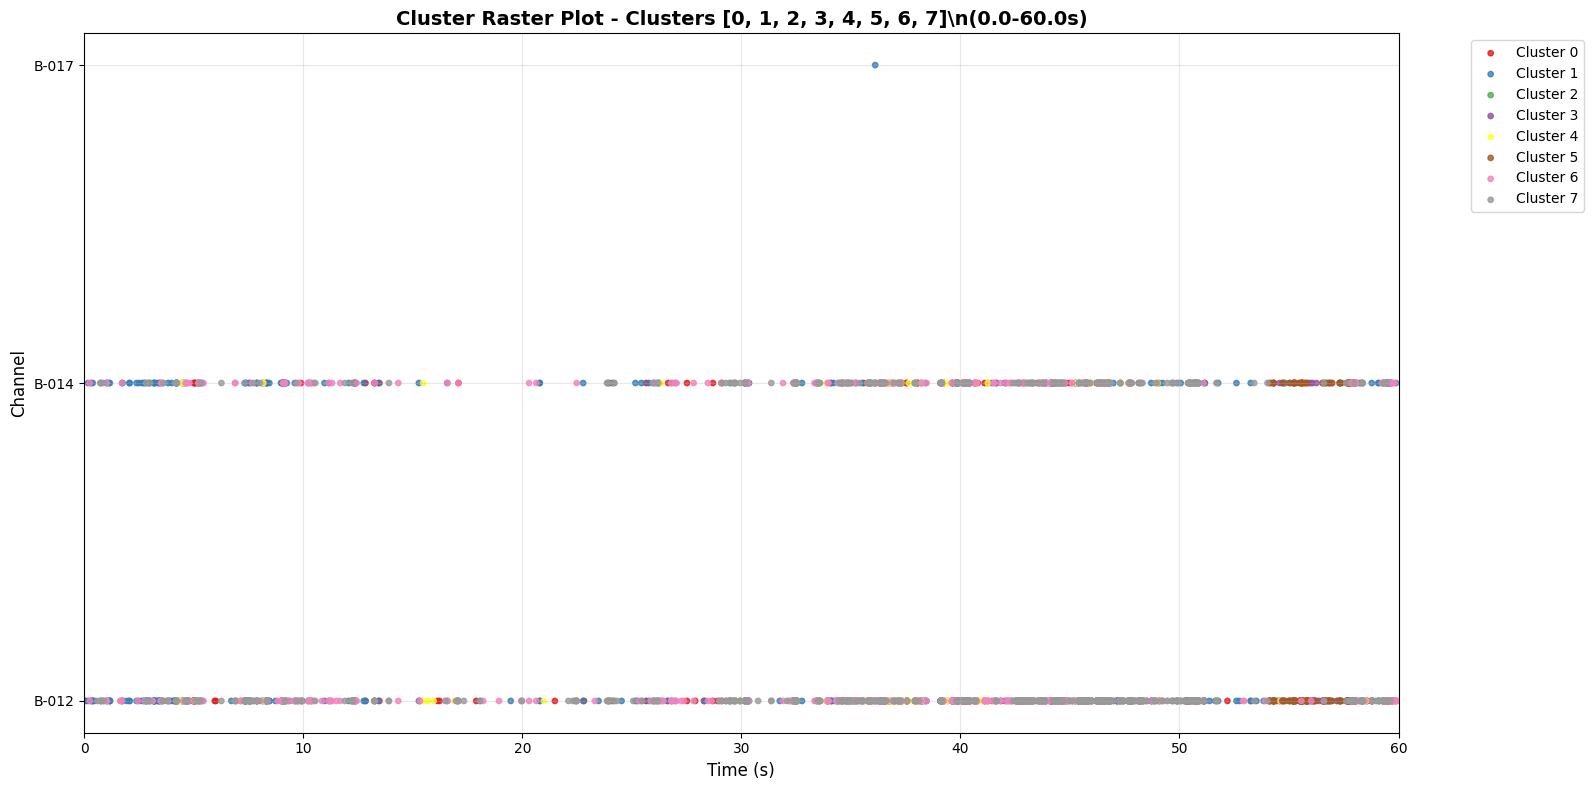

\nCluster Statistics for time window 0.0-60.0s:
--------------------------------------------------
Cluster 0:
  - Spikes in window: 362
  - Spike rate: 6.03 Hz
  - Active channels: ['B-012']

Cluster 1:
  - Spikes in window: 758
  - Spike rate: 12.63 Hz
  - Active channels: ['B-012']

Cluster 2:
  - Spikes in window: 100
  - Spike rate: 1.67 Hz
  - Active channels: ['B-012']

Cluster 3:
  - Spikes in window: 72
  - Spike rate: 1.20 Hz
  - Active channels: ['B-012']

Cluster 4:
  - Spikes in window: 212
  - Spike rate: 3.53 Hz
  - Active channels: ['B-012']

Cluster 5:
  - Spikes in window: 158
  - Spike rate: 2.63 Hz
  - Active channels: ['B-012']

Cluster 6:
  - Spikes in window: 573
  - Spike rate: 9.55 Hz
  - Active channels: ['B-012']

Cluster 7:
  - Spikes in window: 500
  - Spike rate: 8.33 Hz
  - Active channels: ['B-012']

Total spikes (selected clusters): 2735
Overall rate (selected clusters): 45.58 Hz
\n2. Selected clusters [0, 3, 4] (0-60s):
Plotting raster for clusters: [0,

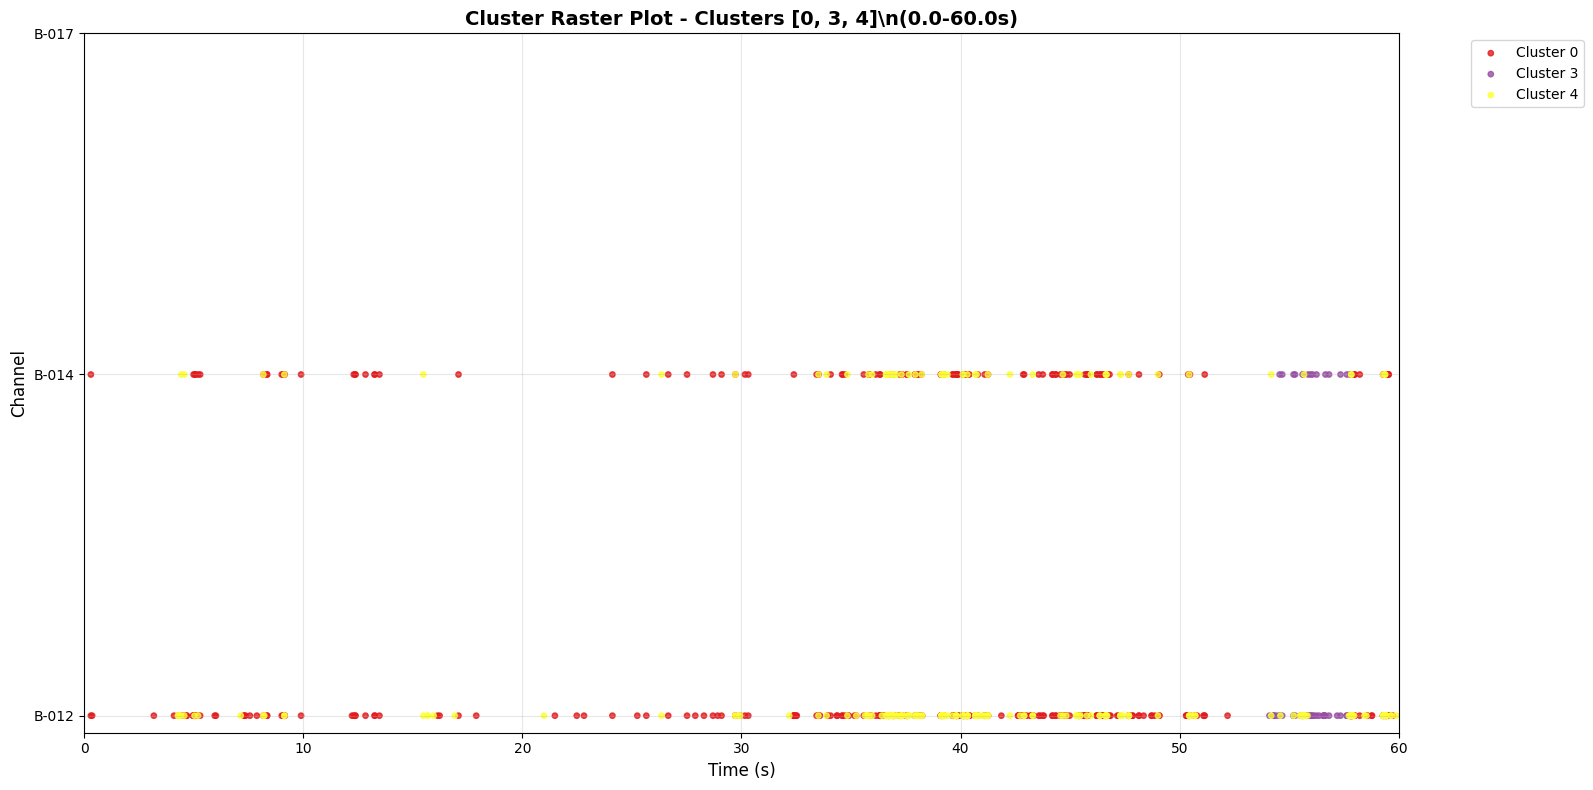

\nCluster Statistics for time window 0.0-60.0s:
--------------------------------------------------
Cluster 0:
  - Spikes in window: 362
  - Spike rate: 6.03 Hz
  - Active channels: ['B-012']

Cluster 3:
  - Spikes in window: 72
  - Spike rate: 1.20 Hz
  - Active channels: ['B-012']

Cluster 4:
  - Spikes in window: 212
  - Spike rate: 3.53 Hz
  - Active channels: ['B-012']

Total spikes (selected clusters): 646
Overall rate (selected clusters): 10.77 Hz


In [21]:
def plot_cluster_raster(selected_clusters=None, start_time=None, end_time=None, figsize=(16, 8)):
    """
    Plot raster plot showing only spikes from selected clusters
    
    Parameters:
    -----------
    selected_clusters : list or None
        List of cluster IDs to plot (e.g., [0, 3, 4]). If None, plots all clusters.
    start_time : float or None
        Start time in seconds. If None, uses full recording.
    end_time : float or None
        End time in seconds. If None, uses full recording.
    figsize : tuple
        Figure size
    """
    
    # Check if clustering results exist
    if 'cluster_labels' not in locals() and 'cluster_labels' not in globals():
        print("Error: No clustering results found. Please run clustering analysis first.")
        return
    
    # Use global cluster_labels if not in local scope
    if 'cluster_labels' not in locals():
        global cluster_labels, optimal_k, spike_times_by_channel, pin_columns
    
    # Set time range
    if start_time is None:
        start_time = processed_df['time'].min()
    if end_time is None:
        end_time = processed_df['time'].max()
    
    # Set default clusters if not specified
    if selected_clusters is None:
        selected_clusters = list(range(optimal_k))
    
    print(f"Plotting raster for clusters: {selected_clusters}")
    print(f"Time range: {start_time:.1f} - {end_time:.1f} seconds")
    
    # Create mapping from spike times to cluster labels
    spike_cluster_map = {}
    spike_channel_map = {}
    spike_idx = 0
    
    # Map each spike to its cluster and channel
    for channel in pin_columns:
        channel_spikes = spike_times_by_channel[channel]
        for spike_time in channel_spikes:
            if spike_idx < len(cluster_labels):
                spike_cluster_map[spike_time] = cluster_labels[spike_idx]
                spike_channel_map[spike_time] = channel
                spike_idx += 1
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Define colors for clusters
    cluster_colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
    
    # Plot spikes for each selected cluster
    for cluster_id in selected_clusters:
        y_positions = []
        spike_times_plot = []
        
        for i, channel in enumerate(pin_columns):
            channel_spikes = spike_times_by_channel[channel]
            
            # Filter spikes by time window and cluster
            for spike_time in channel_spikes:
                if (start_time <= spike_time <= end_time and 
                    spike_time in spike_cluster_map and 
                    spike_cluster_map[spike_time] == cluster_id):
                    
                    y_positions.append(i)
                    spike_times_plot.append(spike_time)
        
        if spike_times_plot:
            ax.scatter(spike_times_plot, y_positions, 
                      c=[cluster_colors[cluster_id]] * len(spike_times_plot), 
                      label=f'Cluster {cluster_id}', s=15, alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Channel', fontsize=12)
    ax.set_title(f'Cluster Raster Plot - Clusters {selected_clusters}\\n({start_time:.1f}-{end_time:.1f}s)', 
                fontsize=14, fontweight='bold')
    ax.set_yticks(range(len(pin_columns)))
    ax.set_yticklabels(pin_columns)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(start_time, end_time)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for selected clusters
    print(f"\\nCluster Statistics for time window {start_time:.1f}-{end_time:.1f}s:")
    print("-" * 50)
    
    total_spikes_in_window = 0
    for cluster_id in selected_clusters:
        cluster_spike_count = 0
        cluster_channels = set()
        
        for spike_time, cluster_label in spike_cluster_map.items():
            if (cluster_label == cluster_id and 
                start_time <= spike_time <= end_time):
                cluster_spike_count += 1
                cluster_channels.add(spike_channel_map[spike_time])
        
        total_spikes_in_window += cluster_spike_count
        window_duration = end_time - start_time
        spike_rate = cluster_spike_count / window_duration if window_duration > 0 else 0
        
        print(f"Cluster {cluster_id}:")
        print(f"  - Spikes in window: {cluster_spike_count}")
        print(f"  - Spike rate: {spike_rate:.2f} Hz")
        print(f"  - Active channels: {sorted(list(cluster_channels))}")
        print()
    
    print(f"Total spikes (selected clusters): {total_spikes_in_window}")
    print(f"Overall rate (selected clusters): {total_spikes_in_window/(end_time-start_time):.2f} Hz")

# Example usage:
print("Creating cluster-specific raster plots...")
print("\\nAvailable clusters:", list(range(optimal_k)))

# Plot all clusters for first 60 seconds
print("\\n1. All clusters (0-60s):")
plot_cluster_raster(selected_clusters=None, start_time=0, end_time=60)

# Plot specific clusters
print("\\n2. Selected clusters [0, 3, 4] (0-60s):")
plot_cluster_raster(selected_clusters=[0, 3, 4], start_time=0, end_time=60)

CLUSTER RASTER PLOT EXAMPLES
\nExample 1: Clusters [0, 3, 4] from 100-200 seconds
Plotting raster for clusters: [0, 3, 4]
Time range: 100.0 - 200.0 seconds


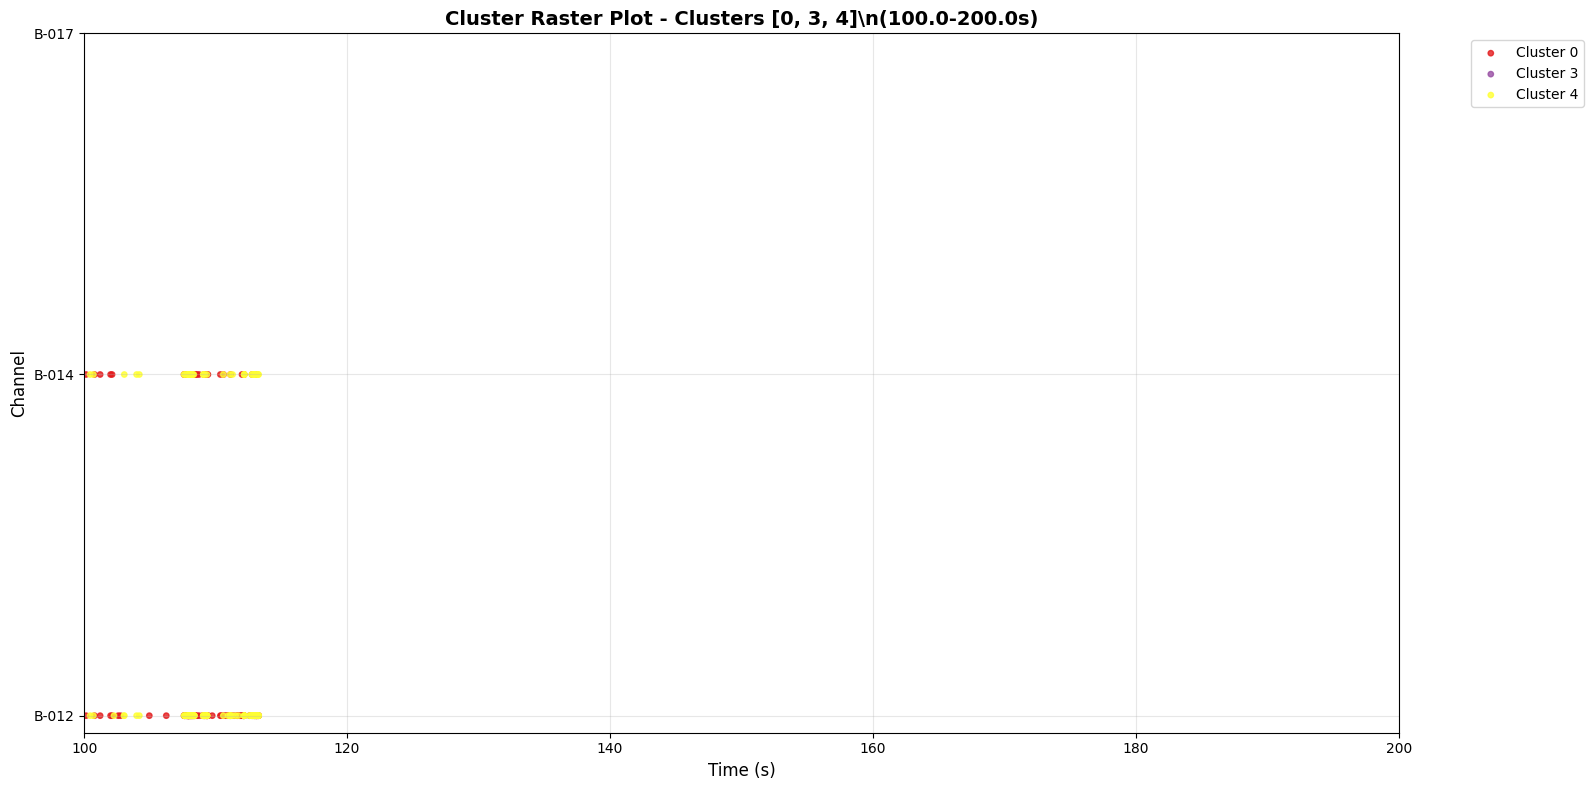

\nCluster Statistics for time window 100.0-200.0s:
--------------------------------------------------
Cluster 0:
  - Spikes in window: 136
  - Spike rate: 1.36 Hz
  - Active channels: ['B-012']

Cluster 3:
  - Spikes in window: 3
  - Spike rate: 0.03 Hz
  - Active channels: ['B-012']

Cluster 4:
  - Spikes in window: 94
  - Spike rate: 0.94 Hz
  - Active channels: ['B-012']

Total spikes (selected clusters): 233
Overall rate (selected clusters): 2.33 Hz
\nExample 2: Only Cluster 0 for full recording
Plotting raster for clusters: [0]
Time range: 0.0 - 679.5 seconds


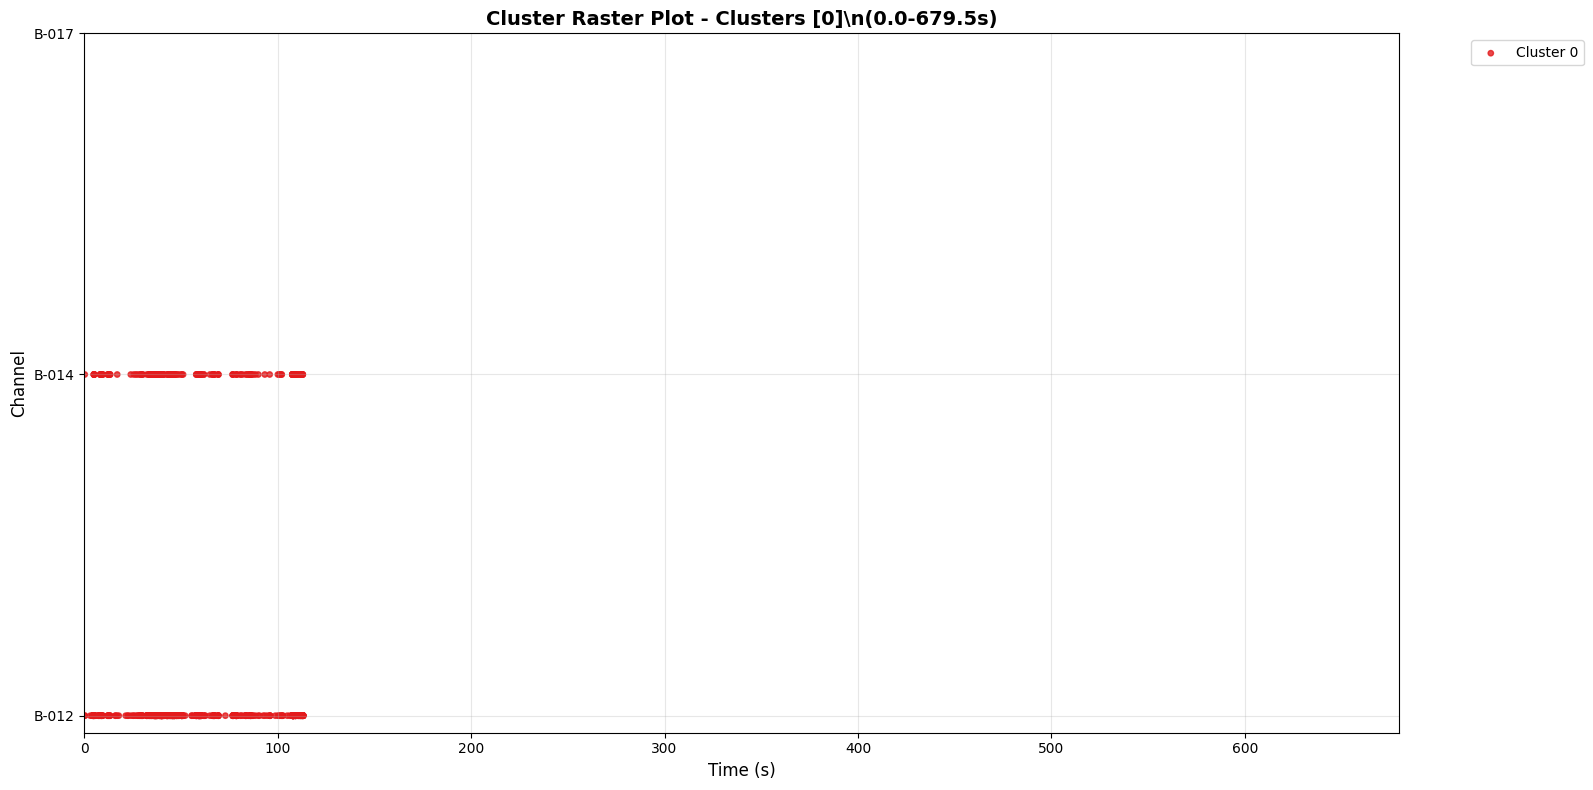

\nCluster Statistics for time window 0.0-679.5s:
--------------------------------------------------
Cluster 0:
  - Spikes in window: 596
  - Spike rate: 0.88 Hz
  - Active channels: ['B-012']

Total spikes (selected clusters): 596
Overall rate (selected clusters): 0.88 Hz
\nExample 3: Clusters [1, 2, 5] with larger figure
Plotting raster for clusters: [1, 2, 5]
Time range: 0.0 - 100.0 seconds


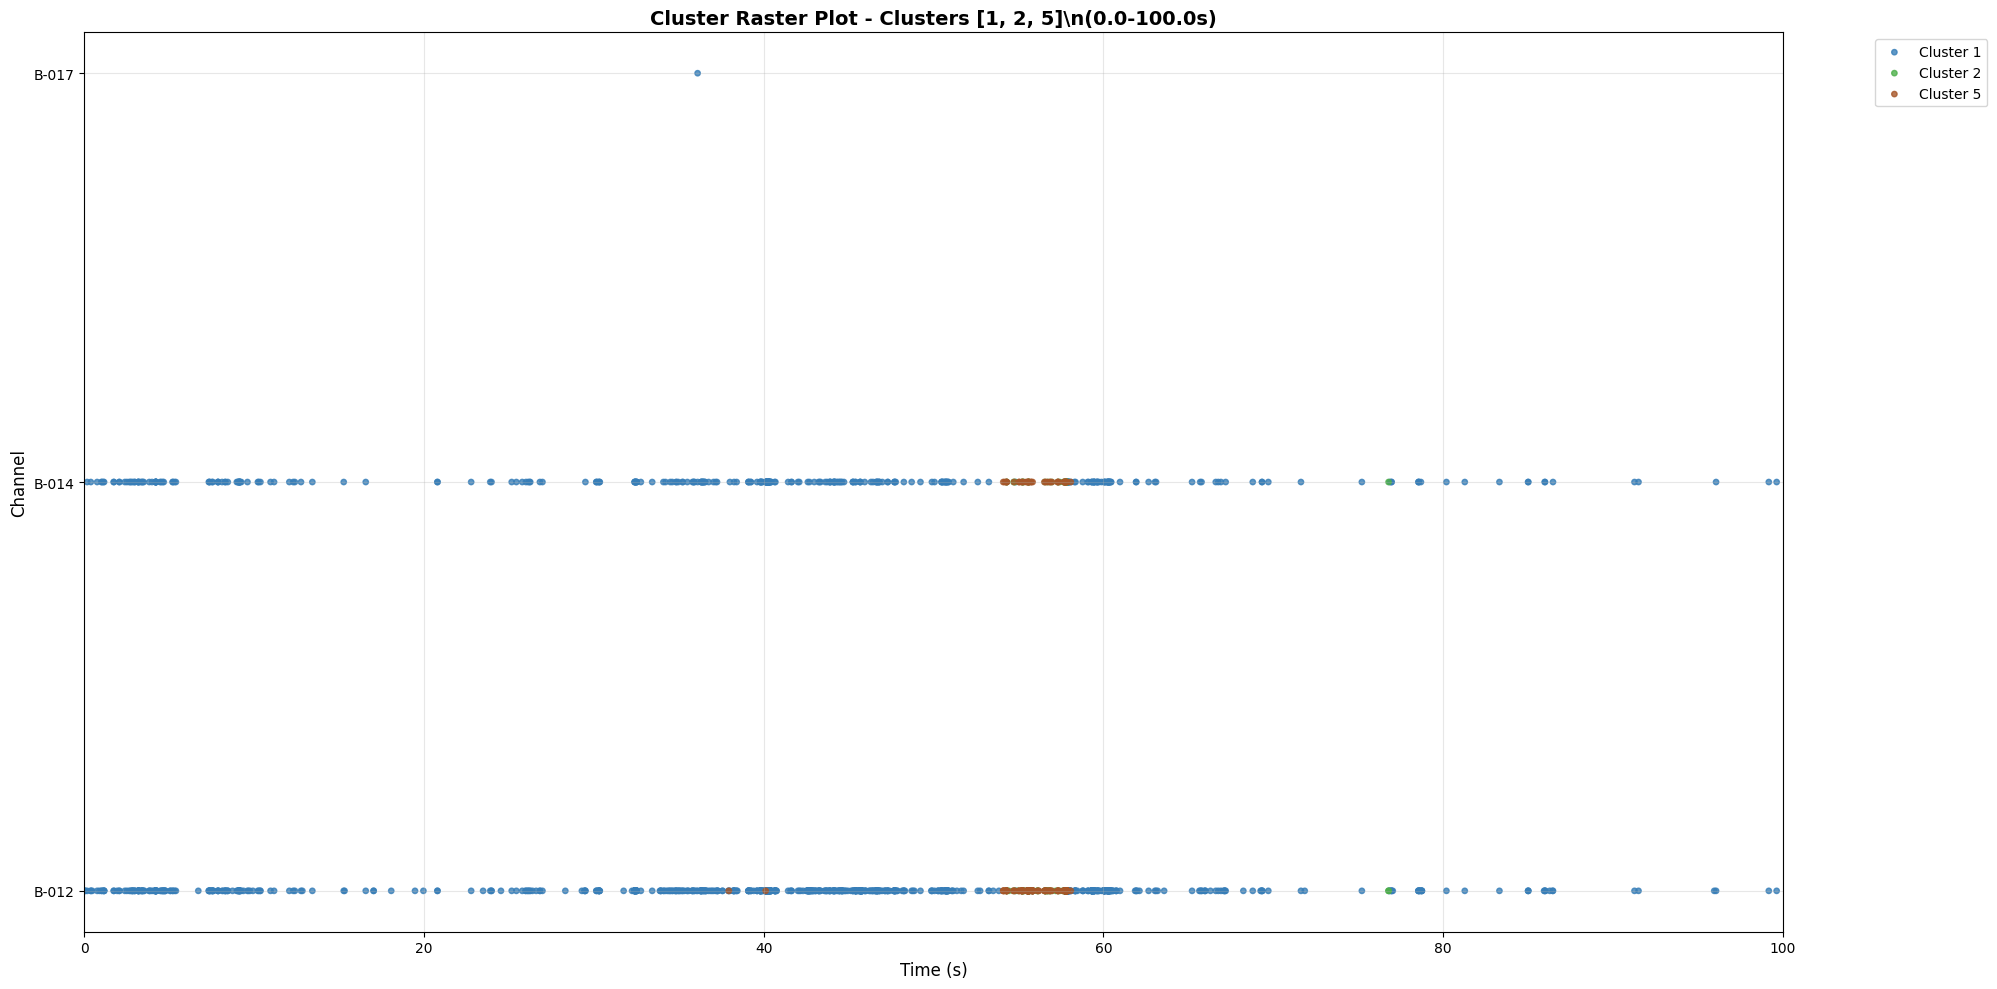

\nCluster Statistics for time window 0.0-100.0s:
--------------------------------------------------
Cluster 1:
  - Spikes in window: 894
  - Spike rate: 8.94 Hz
  - Active channels: ['B-012']

Cluster 2:
  - Spikes in window: 102
  - Spike rate: 1.02 Hz
  - Active channels: ['B-012']

Cluster 5:
  - Spikes in window: 158
  - Spike rate: 1.58 Hz
  - Active channels: ['B-012']

Total spikes (selected clusters): 1154
Overall rate (selected clusters): 11.54 Hz
\n============================================================
USAGE GUIDE
Use the plot_cluster_raster() function with these parameters:
\n• selected_clusters: [0, 3, 4] - List of cluster IDs to display
• start_time: 0 - Start time in seconds (optional)
• end_time: 60 - End time in seconds (optional)
• figsize: (16, 8) - Figure size as (width, height)
\nExamples:
plot_cluster_raster([0, 3, 4])  # Plot clusters 0, 3, 4 for full recording
plot_cluster_raster([1], 50, 150)  # Plot cluster 1 from 50-150 seconds
plot_cluster_raster([0, 2,

In [22]:
# Additional examples for cluster-specific raster plots

print("="*60)
print("CLUSTER RASTER PLOT EXAMPLES")
print("="*60)

# Example 1: Plot only clusters 0, 3, 4 for a specific time window
print("\\nExample 1: Clusters [0, 3, 4] from 100-200 seconds")
plot_cluster_raster(selected_clusters=[0, 3, 4], start_time=100, end_time=200)

# Example 2: Plot single cluster for full recording
print("\\nExample 2: Only Cluster 0 for full recording")
plot_cluster_raster(selected_clusters=[0])

# Example 3: Plot multiple specific clusters with custom figure size
print("\\nExample 3: Clusters [1, 2, 5] with larger figure")
plot_cluster_raster(selected_clusters=[1, 2, 5], start_time=0, end_time=100, figsize=(20, 10))

print("\\n" + "="*60)
print("USAGE GUIDE")
print("="*60)
print("Use the plot_cluster_raster() function with these parameters:")
print("\\n• selected_clusters: [0, 3, 4] - List of cluster IDs to display")
print("• start_time: 0 - Start time in seconds (optional)")
print("• end_time: 60 - End time in seconds (optional)")
print("• figsize: (16, 8) - Figure size as (width, height)")
print("\\nExamples:")
print("plot_cluster_raster([0, 3, 4])  # Plot clusters 0, 3, 4 for full recording")
print("plot_cluster_raster([1], 50, 150)  # Plot cluster 1 from 50-150 seconds")
print("plot_cluster_raster([0, 2, 7], 0, 30, (20, 6))  # Custom time and size")